<a href="https://colab.research.google.com/github/JunHyeong-data/ML-DL-Study/blob/main/Basic-Deep-Learning/19_%EB%94%A5%EB%9F%AC%EB%8B%9D%2C_CNN%2C_module%2C_%EB%94%94%EC%9E%90%EC%9D%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

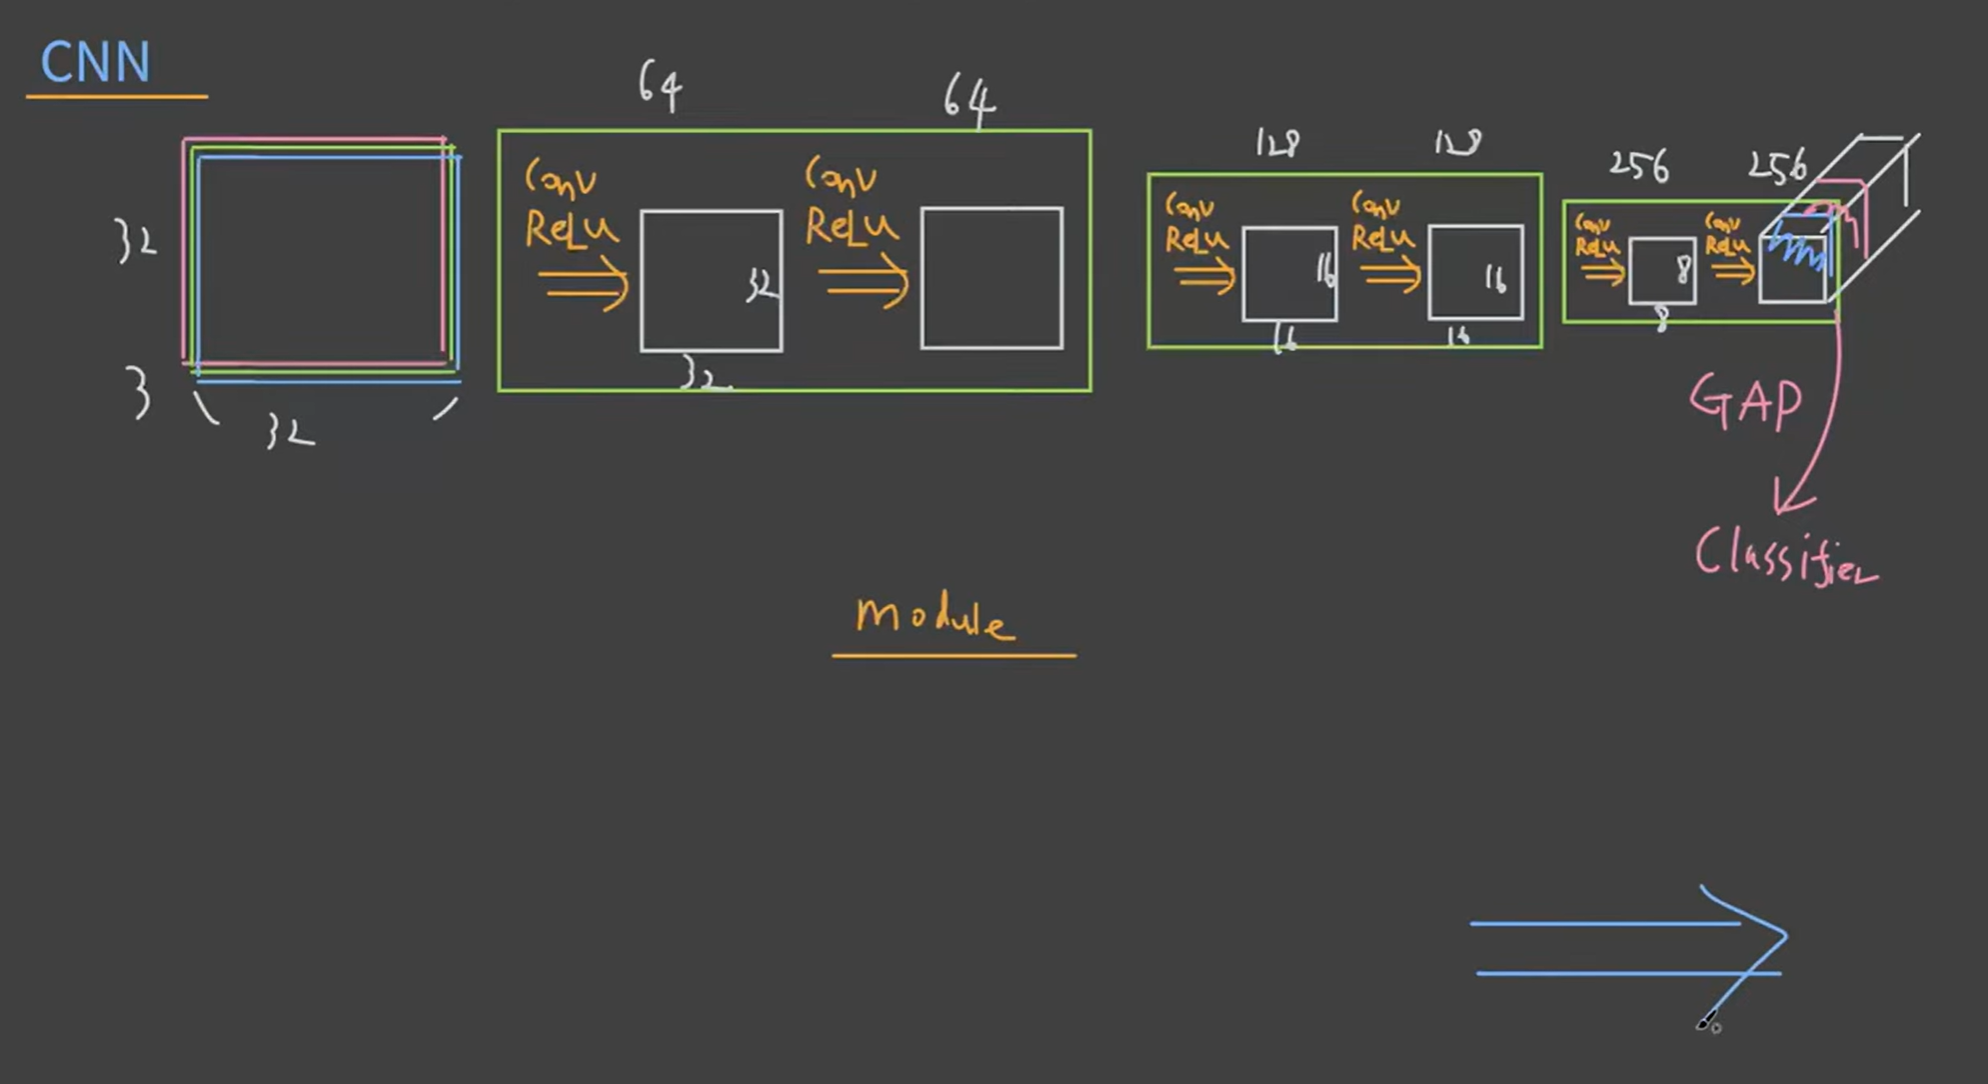

# Convolutional Neural Network (CNN) 기초 복습 & PyTorch 구현

## 1. CNN 개요

이미지는 가로·세로의 **공간 정보(spatial information)** 를 본질적으로 가지고 있다.  
이러한 특성 때문에 **Convolution 연산**은 이미지로부터 특징(feature)을 추출하는 데 매우 효과적이다.

- Convolution + Activation을 반복하면서 특징을 점점 정제
- 학습 과정에서 **Loss를 최소화하는 feature**들이 자동으로 학습됨
- 앞단: **Low-level feature** (edge, texture)
- 뒷단: **High-level feature** (object, shape)

CNN 아키텍처는 크게 두 부분으로 나눌 수 있다.

1. **Feature Extractor**
2. **Classifier**

---

## 2. CNN 아키텍처 트렌드

과거 CNN 구조:
- Fully Connected Layer 사용
- Pooling Layer 사용

최근 CNN 구조:
- **Global Average Pooling (GAP)** 사용
- Pooling 대신 **Stride가 있는 Convolution**
- Activation 이전에 **Batch Normalization** 삽입

이러한 구조는:
- 학습을 더 빠르게 함
- 학습을 더 안정적으로 만듦
- 파라미터 수 감소 → 일반화 성능 향상

---

## 3. 데이터셋: CIFAR-10

- 이미지 크기: **32 × 32**
- 채널 수: **RGB (3채널)**
- 클래스 수: **10개**

전처리 과정:
- Tensor 변환
- Mean = 0.5, Variance = 0.5로 정규화

---

## 4. PyTorch 모듈러 디자인 개념

PyTorch의 핵심 강점 중 하나는 **모듈러 디자인**이다.

- `nn.Module`을 상속받아 블록 단위로 네트워크 구성
- 한 번 정의한 블록을 **재사용 가능**
- VGG, ResNet 등 대부분의 CNN 구조에서 동일한 패턴 반복

---

## 5. Base Block 설계

### 구조
- Conv2D
- BatchNorm
- Activation
- Conv2D
- BatchNorm
- Activation

### 특징
- Kernel Size = 3
- 첫 번째 Conv에서 stride 조절 가능
- Forward에서는 Sequential block만 실행

```text
Conv → BN → Act → Conv → BN → Act
````

---

## 6. 전체 CNN 구조 설계

Base Block을 반복하여 전체 네트워크 구성

### Block 구성

| Block   | Output Channels | Stride | Spatial Size |
| ------- | --------------- | ------ | ------------ |
| Input   | 3               | -      | 32 × 32      |
| Block 1 | 64              | 1      | 32 × 32      |
| Block 2 | 128             | 2      | 16 × 16      |
| Block 3 | 256             | 2      | 8 × 8        |

* Stride = 2 → 공간 크기 절반 감소
* 채널 수는 점점 증가

---

## 7. Global Average Pooling & Classifier

* 마지막 Feature Map에 **Global Average Pooling** 적용
* Fully Connected Layer 없이 분류기 구현
* 파라미터 수 감소 + 과적합 완화

---

## 8. 학습 설정

* Loss Function: **Cross Entropy Loss**
* Optimizer: **Adam**
* Epochs: **100**
* Device: GPU (CUDA 사용)

### Training Loop 요약

1. 모델을 train 모드로 설정
2. 데이터 & 레이블을 GPU로 이동
3. Forward Pass
4. Loss 계산
5. Backpropagation
6. Optimizer Step

### Validation

* `torch.no_grad()` 사용
* Accuracy 계산

---

## 9. 학습 결과

* 초기 정확도: 약 **40%**
* CNN 구조 개선 후:

  * Global Average Pooling
  * Batch Normalization
  * Stride CNN
* 최종 정확도: **80% 이상**

---

## 10. 정리

이번 강의에서 다룬 핵심:

* CNN 기본 개념 복습
* Feature Extractor vs Classifier
* 최신 CNN 아키텍처 트렌드
* PyTorch 모듈러 디자인
* 재사용 가능한 Base Block 설계

다음 강의:

* **Data Augmentation**
* 모델 성능을 한 단계 더 끌어올리는 기법

기초를 탄탄히 다지는 것이 가장 중요하다.

In [3]:
import torch
import torchvision
import matplotlib.pyplot as plt

if torch.backends.mps.is_available():
  my_device = torch.device('mps')
elif torch.cuda.is_available():
  my_device = torch.device('cuda')
else:
  my_device = torch.device('cpu')

print(my_device)

cpu


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

# Load CIFAR10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16, shuffle=True, num_workers=4)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=16, shuffle=False, num_workers=4)

In [14]:
class DoubleConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.block(x)

class ModernGAPCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        self.features = nn.Sequential(
            DoubleConvBlock(3, 64),
            DoubleConvBlock(64, 128, stride=2),
            DoubleConvBlock(128, 256, stride=2),
        )

        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = self.global_avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Instantiate the network
net = ModernGAPCNN(num_classes=10)



# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)

In [15]:
net.to(my_device)
num_epochs = 100
for epoch in range(num_epochs):
    net.train()
    for batch_idx, (data, label) in enumerate(trainloader):
        data, label = data.to(my_device), label.to(my_device)
        scores = net(data)
        loss = criterion(scores, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    net.eval()

    with torch.no_grad():
        val_loss = 0.0
        correct = 0
        for data, label in testloader:
            data, label = data.to(my_device), label.to(my_device)
            scores = net(data)
            loss = criterion(scores, label)
            val_loss += loss.item() * data.size(0)

            predicted = scores.argmax(dim=1)
            correct += predicted.eq(label).sum().item()

        val_loss /= len(testloader.dataset)
        val_accuracy = 100. * correct / len(testloader.dataset)

    print(f"Epoch [{epoch + 1}/{num_epochs}], Training Loss: {loss.item():.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

KeyboardInterrupt: 